# <center> **PROJECT 5. Regression Task**

## <center> **`1.` Formulation of the task**

**Business task:** determine the characteristics and use them to predict the duration of a taxi ride. 

**Technical task:** It is necessary to build a machine learning model that, based on the proposed characteristics of the client, will predict a numerical feature - the taxi ride time, that is, solve the regression task.

#### **BASIC GOALS:**

* Form a data set based on several sources of information.

* Design new features using *Feature Engineering* and identify the most significant when building a model.

* Explore the data provided and identify patterns.

* Build several models and choose from them the one that shows the best result for a given metric.

* Design a trip duration prediction process for new data.


#### <center> **ORGANIZATIONAL INFORMATION**

The project will consist of five parts:

`1.` **Primary data processing**;

`2.` **Exploratory data analysis (EDA)**;

`3.` **Selection and transformation of features**;

`4.` **Solving a Regression Task: Linear Regression and Decision Trees**;

`5.` **Solving the Regression Task: Ensembles of Models and Building a Forecast**.

## <center> **`2.` Introduction to data. Basic analysis and data enhancement**

We import the modules that we need to solve the task in advance:

In [1]:
# For work with data
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# For work with data and build a model
from scipy import stats
from scipy.stats import normaltest
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
import xgboost as xgb

Read the source file:

In [2]:
# Load a train DataFrame
taxi_data = pd.read_csv('Прочие файлы/train.csv')

# Create the copy
taxi_df = taxi_data.copy()

In [ ]:
# Display a first five strings
taxi_df.head()

In [ ]:
# Display data dimensions
print('Data shape: {}'.format(taxi_df.shape))

#### $Information$ $about$ $DataFrame$

So, we have data on almost 1.5 million trips and 11 features that describe each of the trips.

We conditionally divided the signs into several groups. We will pay special attention to each of the groups in the future.

*Data about the client and the taxi fleet:*
* `id` - unique trip ID
* `vendor_id` - unique identifier of the supplier (taxi fleet) associated with the trip record

*Timing:*
* `pickup_datetime` - date and time the trip meter was turned on
* `dropoff_datetime` - date and time the meter was disabled

*Geographic information:*
* `pickup_longitude` -  longitude at which counter was enabled
* `pickup_latitude` - latitude at which counter was enabled
* `dropoff_longitude` - longitude at which counter was disabled
* `dropoff_latitude` - latitude at which counter was disabled

*Other features:*
* `passenger_count` - count of passengers in the vehicle (value entered by the driver)
* `store_and_fwd_flag` - a flag that indicates whether the trip record was stored in the vehicle's memory before it was sent to the supplier. `Y` - store and forward, `N` - do not store or forward the trip.

**Target feature:**
* `trip_duration` - trip duration in seconds

#### $2.1$ 

Let's do a little research on the data.

Let's convert the `pickup_datetime` and `dropoff_datetime` features into the *datetime* data type.

In [3]:
# We convert the 'pickup_datetime' feature
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

# We convert the 'dropoff_datetime' feature
taxi_df['dropoff_datetime'] = pd.to_datetime(taxi_df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

#### $2.2$

Look at the number of missing values.

In [4]:
taxi_df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

#### $2.3$

Let's look at the statistical characteristics of some features.

In [5]:
# We output a nunique taxi companies
print('Count the nunique taxi companies: {}'.format(taxi_df.vendor_id.nunique()))

# We output a maximum count of passengers
print('Maximum count of passengers: {}'.format(taxi_df.passenger_count.max()))

# We output a minimum count of passengers
print('Minimum count of passengers: {}'.format(taxi_df.passenger_count.min()))

# We output an average trip duration in seconds
print('Average trip duration: {}'.format(round(taxi_df.trip_duration.mean())))

# We output a median trip duration in seconds
print('Median trip duration: {}'.format(round(taxi_df.trip_duration.median())))

# We output minimum time of the trip in seconds
print('Minimum time of the trip: {}'.format(taxi_df.trip_duration.min()))

# We output maximum time of the trip in seconds
print('Maximum time of the trip: {}'.format(taxi_df.trip_duration.max()))

Count the nunique taxi companies: 2
Maximum count of passengers: 9
Minimum count of passengers: 0
Average trip duration: 959
Median trip duration: 662
Minimum time of the trip: 1
Maximum time of the trip: 3526282


#### $2.4$

From `pickup_datetime` feature create 3 new features: 

* `pickup_date`, 
* `pickup_hour`, 
* `pickup_day_of_week`

In [6]:
def add_datetime_features(df):
    
    # Create the 'pickup_date' feature
    df['pickup_date'] = pd.to_datetime(df.pickup_datetime).dt.date.astype('datetime64[D]')
    
    # Create the 'pickup_hour' feature
    df['pickup_hour'] = pd.to_datetime(df.pickup_datetime).dt.hour
    
    # Create the 'pickup_day_of_week' feature
    df['pickup_day_of_week'] = pd.to_datetime(df.pickup_datetime).dt.day_name()
    
    return df


# We apply the resulting function to the entire DataFrame
taxi_df = add_datetime_features(taxi_df)

In [7]:
# Output number of trips by day of the week.
taxi_df.groupby('pickup_day_of_week')['id'].count()

pickup_day_of_week
Friday       223533
Monday       187418
Saturday     220868
Sunday       195366
Thursday     218574
Tuesday      202749
Wednesday    210136
Name: id, dtype: int64

In [8]:
# Output the average number of trips per day
print('Average number of trips per day: {}'.format(round(taxi_df.groupby('pickup_date')['id'].count().mean())))

Average number of trips per day: 8015


The situation on the roads often depends on whether the day is a holiday. A large number of cars creates traffic jams and potentially increases the duration of a taxi trip.

Let's add information to our dataset about whether the day is a holiday. The added dataset contains information with the dates of all holidays in America for 2016. The data is presented in `CSV` tabular format and contains three columns:

* `day`
* `date`
* `holiday` 

In [9]:
# Load a holiday_data DataFrame
holiday_df = pd.read_csv('Прочие файлы/holiday_data.csv', sep=';')

# We conwert a 'date' feature from dtype 'object' to 'datetime64[ns]'
holiday_df.date = pd.to_datetime(holiday_df.date, format='%Y-%m-%d')

#### $2.5$

Implement the `add_holiday_features()` function, which takes two tables (trip data and holiday data) as input and returns an updated trip data table with the *pickup_holiday* column added to it, a binary indication of whether the trip started on a holiday ( 1 - yes, 0 - no).

In [10]:
def add_holiday_features(df1, df2):
    
    
    # Merge df1 and df2 DataFrame's
    df1 = df1.merge(
        df2,
        left_on = ['pickup_date', 'pickup_day_of_week'],
        right_on = ['date', 'day'],
        how = 'left'
    )
    
    
    # Filling NaN by 'Typical day' string
    df1['holiday'] = df1['holiday'].fillna('Typical Day')
    
    # Change the 'holiday' feature to binary
    df1['holiday'] = df1['holiday'].apply(lambda x: 1 if x != 'Typical Day' else 0)
    
    # Delete unnecessary columns
    df1 = df1.drop(columns = ['day', 'date'], axis=1)
    
    
    return df1


# We apply the resulting function to the entire dataframe
taxi_df = add_holiday_features(df1=taxi_df, df2=holiday_df)

In [11]:
# Create a holiday_days_df DataFrame
holidays_df = taxi_df[taxi_df['holiday'] == 1]

# Output the median trip duration in holidays
print('The median trip duration in holidays: {}'.format(round(holidays_df.groupby('holiday')['trip_duration'].median())))

The median trip duration in holidays: holiday
1    585.0
Name: trip_duration, dtype: float64


Let's move on to **geographic** characteristics. The data has columns containing latitude and longitude information.

A lot of useful information can be extracted from them.

To do this, we will use unloading from *OSRM API*.

The datasets are presented in tabular `CSV` format. We will only be interested in the following columns:

* `id` — trip identifier;

* `total_distance` - the shortest road distance (in meters) from the point where the counter was turned on to the point where the counter was turned off (according to *OSRM*);

* `total_travel_time` - the shortest travel time (in seconds) from the point at which the counter was turned on to the point at which the counter was turned off (according to *OSRM*);

* `number_of_steps` is the number of discrete steps the driver must take (turn left/turn right/go straight, etc.).

In [12]:
# Load a OSRM DataFrame
osrm_data = pd.read_csv('Прочие файлы/osrm_data_train.csv')

# Create a copy
osrm_df = osrm_data.copy()

In [ ]:
# Output the first five strings
osrm_df.head()

#### $2.6$

Let's implement the `add_osrm_features()` function, which takes two tables as input (with data on trips and data from *OSRM*) and returns an updated table with trip data with three columns added to it:

* `total_distance`;
* `total_travel_time`;
* `number_of_steps`.


We will only be interested in the following columns:

* `id` — trip ID;

* `total_distance` — shortest driving distance (in meters) from the point where the meter was turned on to the point where the meter was turned off (according to *OSRM*);

* `total_travel_time` — shortest travel time (in seconds) from the point at which the meter was turned on to the point at which the meter was turned off (according to *OSRM*);

* `number_of_steps` — the number of discrete steps the driver must take (turn left/turn right/go straight, etc.).

In [13]:
def add_osrm_features(df1, df2):
       
    # Select necessary columns
    df3 = df2[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
      
    # Merge df1 and df3 DataFrame's
    df1 = df1.merge(
        df3,
        on = 'id',
        how = 'left'
    )
    
    return df1


# We apply the resulting function to the entire dataframe
taxi_df = add_osrm_features(df1=taxi_df, df2=osrm_df)

In [14]:
# Compute the difference between median trip duration and median total travel time
time_difference = taxi_df.trip_duration.median() - taxi_df.total_travel_time.median()

# Output value
print(f'The difference between median trip duration and median total travel time is {round(time_difference)}')

The difference between median trip duration and median total travel time is 372


With the help of geographic characteristics, we can extract some more information. Let's use next functions:

* `get_haversine_distance` — function for calculating the distance using the haversine formula (in kilometers);
* `get_angle_direction` — function for calculating the angle of the direction of movement (in degrees).

Each of the functions has four arguments:

* `lat1` and `lng1` — are column vectors with the latitude and longitude of the first point;
* `lat2` and `lng2` — column vectors with latitude and longitude of the second point.

In [15]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    
    # Convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    # Radius of the earth in kilometers
    EARTH_RADIUS = 6371
    
    # Calculate the shortest distance h using the haversine formula
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    return h




def get_angle_direction(lat1, lng1, lat2, lng2):
    
    # Convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    # We calculate the angle of the direction of movement alpha according to the formula of the bearing angle
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    
    return alpha

#### $2.7$

Let's implement the `add_geographical_features()` function, which will take a trip data table as input and return an updated table with two columns added to it:

* `haversine_distance` — the distance according to the haversine formula between the point at which the counter was turned on and the point at which the counter was turned off;

* `direction` — the direction of movement from the point where the counter was turned on to the point where the counter was turned off.


Then we apply the resulting function to the table.

In [16]:
def add_geographical_features(df):
    
    # We creating the 'haversine_distance' feature
    df['haversine_distance'] = get_haversine_distance(lat1=df.pickup_latitude, lng1=df.pickup_longitude, lat2=df.dropoff_latitude, lng2=df.dropoff_longitude)
    
    # We creating the 'direction' feature
    df['direction'] = get_angle_direction(lat1=df.pickup_latitude, lng1=df.pickup_longitude, lat2=df.dropoff_latitude, lng2=df.dropoff_longitude)
    
    return df


# We apply the resulting function to the entire dataframe
taxi_df = add_geographical_features(df=taxi_df)

In [17]:
# Output the median haversine distance for trips (km)
print('Median haversine distance for trips (in kilometers) is: {}'.format(round(taxi_df.haversine_distance.median(), 2)))

Median haversine distance for trips (in kilometers) is: 2.09


Let's apply clustering by geographical coordinates. As a clustering method, we will use the *K-Means* algorithm. Let's take ten clusters and train it on data formed from the latitude and longitude of all start and end points of trips.

In [18]:
# We create a training sample from the geographical coordinates of all points
coords = np.hstack((
    taxi_df[['pickup_latitude', 'pickup_longitude']],
    taxi_df[['dropoff_latitude', 'dropoff_longitude']]
))


# We train the clustering algorithm
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

c:\Users\ilyaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

#### $2.8$

Let's implement the `add_cluster_features()` function, which takes as input a table with trip data and a trained clustering algorithm. The function will return an updated table with the `geo_cluster` column added to it (the geographic cluster to which the trip belongs).

In [19]:
def add_cluster_features(df, cluster_model):
    
    # Prediction the clusters and creating the 'geo_cluster' feature
    df['geo_cluster'] = cluster_model.predict(df[['pickup_latitude', 'pickup_longitude',
                                                  'dropoff_latitude','dropoff_longitude']].values)
    
    return df


# We apply the resulting function to the entire dataframe
taxi_df = add_cluster_features(df=taxi_df, cluster_model=kmeans)

In [20]:
# Output the number of trips depending on the number of clusters
taxi_df.groupby('geo_cluster')['id'].count()

geo_cluster
0    596467
1      7233
2         2
3     27022
4    359233
5     43619
6        18
7     41171
8         5
9    383874
Name: id, dtype: int64

Read the *weather_data* DataFrame

In [21]:
# Load the weather_data DataFrame
weather_data = pd.read_csv('Прочие файлы/weather_data.csv')

# Create a copy
weather_df = weather_data.copy()

In [ ]:
# Output the first five strings
weather_df.head()

#### $2.9$

Let's implement the `add_weather_features()` function, which takes two tables as input (with data on trips and data on the results of conditions for each hour) and returns an updated table with trip data with five columns added to it:

* `temperature` — temperature;

* `visibility` — visibility;

* `wind speed` — average wind speed;

* `precip` — rainfall;

* `events` — weather conditions.

In [22]:
def add_weather_features(df1, df2):
    
    
    # We convert the 'time' feature from weather_data to dtype datetime64
    df2['time'] = pd.to_datetime(df2['time'], format='%Y-%m-%d %H:%M:%S')
    
    # We create the 'date' from 'time' feature
    df2['date'] = pd.to_datetime(df2.time).dt.date.astype('datetime64[D]')
    
    # We create the 'hour' feature from 'time' feature
    df2['hour'] = pd.to_datetime(df2.time).dt.hour
    
    
    # Delete the unnecessary features
    df2 = df2.drop([
        'time',
        'windchill',
        'heat index',
        'humidity',
        'pressure',
        'dew Point',
        'wind dir',
        'gust speed',
        'conditions'
    ], axis=1)
    
    
    # At last, we merge the df1 and df2 DataFrame's
    df1 = df1.merge(
        df2,
        left_on = ['pickup_date', 'pickup_hour'],
        right_on = ['date', 'hour'],
        how = 'left'
    )
    
    
    # Delete the 'date' and 'hour' features
    df1 = df1.drop([
        'date',
        'hour'
    ], axis=1)
    
    
    return df1



# We apply the resulting function to the entire dataframe
taxi_df = add_weather_features(df1=taxi_df, df2=weather_df)

In [23]:
# Output the count of trips depending on the event conditions
taxi_df.groupby('events')['id'].count()

events
Fog           1
None    1375185
Rain      58300
Snow      13126
Name: id, dtype: int64

In [24]:
# Output the percentage of the total count of observations in the travel data
print(round((taxi_df.isnull().sum() / len(taxi_df)) * 100, 2))

id                    0.00
vendor_id             0.00
pickup_datetime       0.00
dropoff_datetime      0.00
passenger_count       0.00
pickup_longitude      0.00
pickup_latitude       0.00
dropoff_longitude     0.00
dropoff_latitude      0.00
store_and_fwd_flag    0.00
trip_duration         0.00
pickup_date           0.00
pickup_hour           0.00
pickup_day_of_week    0.00
holiday               0.00
total_distance        0.00
total_travel_time     0.00
number_of_steps       0.00
haversine_distance    0.00
direction             0.00
geo_cluster           0.00
temperature           0.82
visibility            0.82
wind speed            0.82
precip                0.82
events                0.82
dtype: float64


#### $2.10$

Let's implement the `fill_null_weather_data()` function, which accepts an input to a trip data table. The function will fill in the missing values ​​in the columns.

In [25]:
def fill_null_weather_data(df):
    
    # Create a weather_columns list
    weather_columns_list = df[['temperature', 'visibility', 'wind speed', 'precip']].columns
    
    # Filling the missing values in 'temperature', 'visibility', 'wind speed' and 'precip' features
    df[weather_columns_list] = df[weather_columns_list].fillna(
        df.groupby('pickup_date')[weather_columns_list].transform('median')
    )
    
    # Filling the missing values in 'events' feature
    df['events'] = df['events'].fillna('None')
    
    # Create a osrm_columns list
    osrm_columns_list = df[['total_distance', 'total_travel_time', 'number_of_steps']].columns
    
    # Filling the missing values in 'total_distance', 'total_travel_time' and 'number_of_steps' features
    df[osrm_columns_list] = df[osrm_columns_list].fillna(df[osrm_columns_list].median())
    
    return df


# We apply the resulting function to the entire dataframe
taxi_df = fill_null_weather_data(df=taxi_df)

In [26]:
# Output the median value from 'temperature' feature
print('The median value of temperature is {}'.format(round(taxi_df.temperature.median(), 1)))

The median value of temperature is 11.1


#### $2.11$

Let's find obvious outliers in the target variable — trip duration. 

Find too long trips. We will agree that trips whose duration exceeds 24 hours will be considered emissions.

It is a little more difficult to analyze trips that are too short, as they include real trips for short distances, trips that were canceled a second after the counter turned on, as well as "teleportations" (moving long distances in a matter of seconds) .

Let us agree that we will consider only the last group as outliers.

Let's build a scatterplot of the average speed of cars.

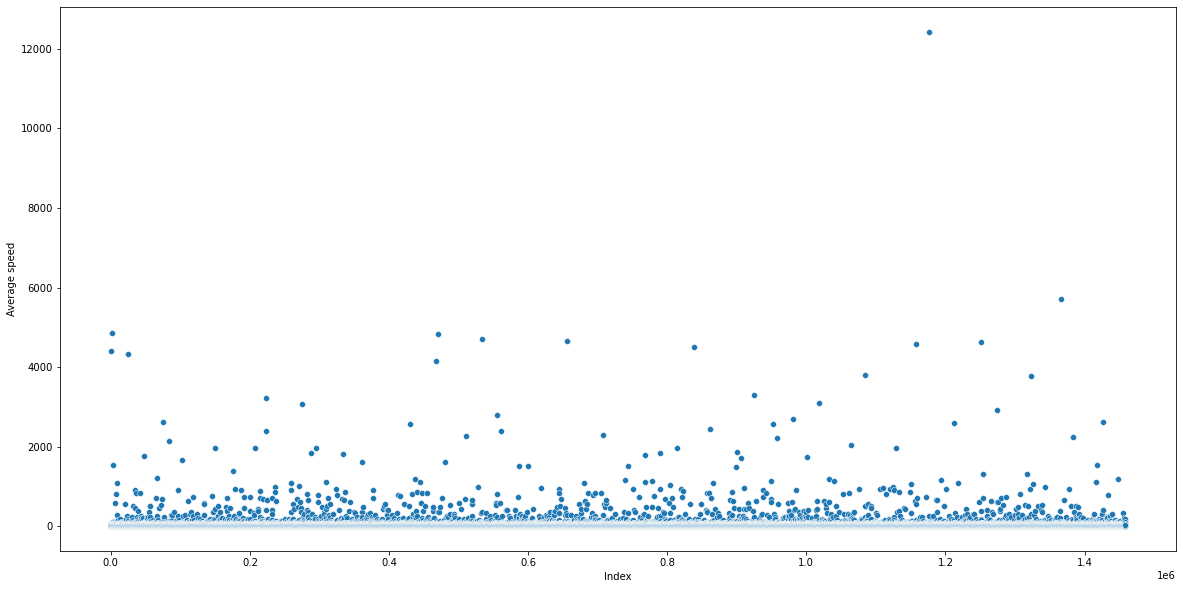

In [27]:
# Conculating the average value of speed
avg_speed = taxi_df['total_distance'] / taxi_df['trip_duration'] * 3.6

# Setting the graph parameters
fig, ax = plt.subplots(figsize = (20, 10))

# Building a scatterplot
sns.scatterplot(
    x = avg_speed.index,
    y = avg_speed,
    ax = ax
)

# Setting a x-axis name
ax.set_xlabel('Index')

# Setting a y-axis name
ax.set_ylabel('Average speed');

Just from here we see that we have "teleportation" trips, for which the average speed is more than 1000 km/h. There is even a trip with an average speed of over 12,000 km/h!

Let's agree that the maximum average speed that the speed of a taxi driver develops will be 300 km/h.

Find trips that are longer than 24 hours and remove them from the dataset.

In [28]:
# Output a count of outliers according to the duration of the trip
outliers_trip_duration = taxi_df[taxi_df.trip_duration > 86400]
print('Count of outliers of the trip duration: {}'.format(outliers_trip_duration.shape[0]))

Count of outliers of the trip duration: 4


Find trips whose average speed along the shortest path exceeds 300 km/h.

In [29]:
# Output a count of outliers according to the maximum speed
outliers_speed = taxi_df[avg_speed > 300]
print('Count of outliers of the average speed: {}'.format(outliers_speed.shape[0]))

Count of outliers of the average speed: 407


Delete the outliers.

In [30]:
# Limiting the maximum value of the trip_duration feature
mask_1 = taxi_df.trip_duration <= 86400

# Limiting the maximum speed
mask_2 = avg_speed <= 300

# Applying the Obtained Constraints to the Dataframe
taxi_df = taxi_df[mask_1 & mask_2]

## <center> **`3.` Exploratory Data Analysis (EDA)**

In this part of the project we:

* examine the generated data set;

* will try to find patterns that allow us to formulate preliminary hypotheses regarding which features are decisive in determining the duration of the trip;

* Will supplement our analysis with visualizations illustrating the study.

The main metric for the quality of the solution to the problem will be **RMSLE (Root Mean Squared Log Error)**, which is calculated based on the target variable on a logarithmic scale.

In this case, it is advisable to immediately take the logarithm of the sign of the duration of the trip and consider the logarithm as the target sign in the analysis:

$$trip\_duration\_log = log(trip\_duration+1),$$

In [31]:
# Take the logarithm of the sign of the trip duration
taxi_df['trip_duration_log'] = np.log(taxi_df['trip_duration'] + 1)

#### $3.1$ 

Building a histogram and a boxplot of the duration of trips on a logarithmic scale ($trip\_duration\_log$).

p = 0.00
The data is not normally distributed (we reject H0)


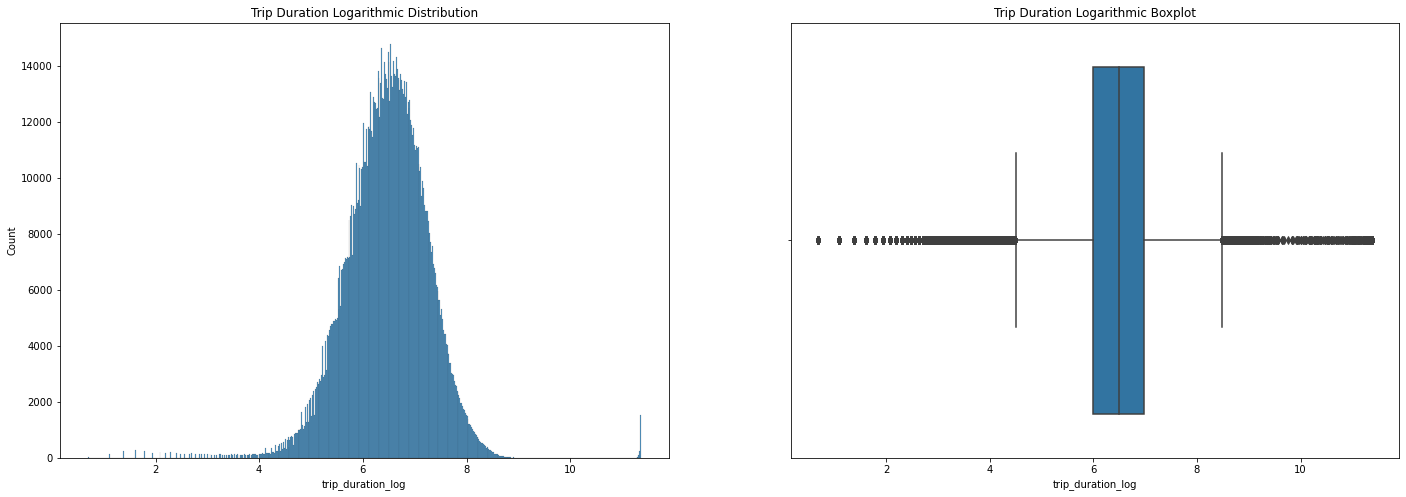

In [32]:
# Set chart parameters
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 8))


# Building a histogram
histplot = sns.histplot(
    data = taxi_df,
    x = 'trip_duration_log',
    ax = axes[0]
);

# Histogram name
histplot.set_title('Trip Duration Logarithmic Distribution')


# Building a box plot
boxplot = sns.boxplot(
    data = taxi_df,
    x = 'trip_duration_log',
    ax = axes[1]
);

# Title of the boxplot
boxplot.set_title('Trip Duration Logarithmic Boxplot');



# We form the null and alternative hypotheses to test the data for normality
H0 = 'Data is normally distributed'
Ha = 'The data is not normally distributed (we reject H0)'


# Set the significance level
alpha = 0.05


# D'Agostino test (returns the two-tailed probability to test a hypothesis)
_, p = normaltest(taxi_df.trip_duration_log)

print('p = %.2f' % p)

# Interpretation
if p > alpha/2:
    print(H0)
else:
    print(Ha)

#### $3.2$ 

We will build a histogram and a box plot that will allow us to compare the distribution of trip duration on a logarithmic scale ($trip\_duration\_log$) depending on the taxi company (`vendor_id`).

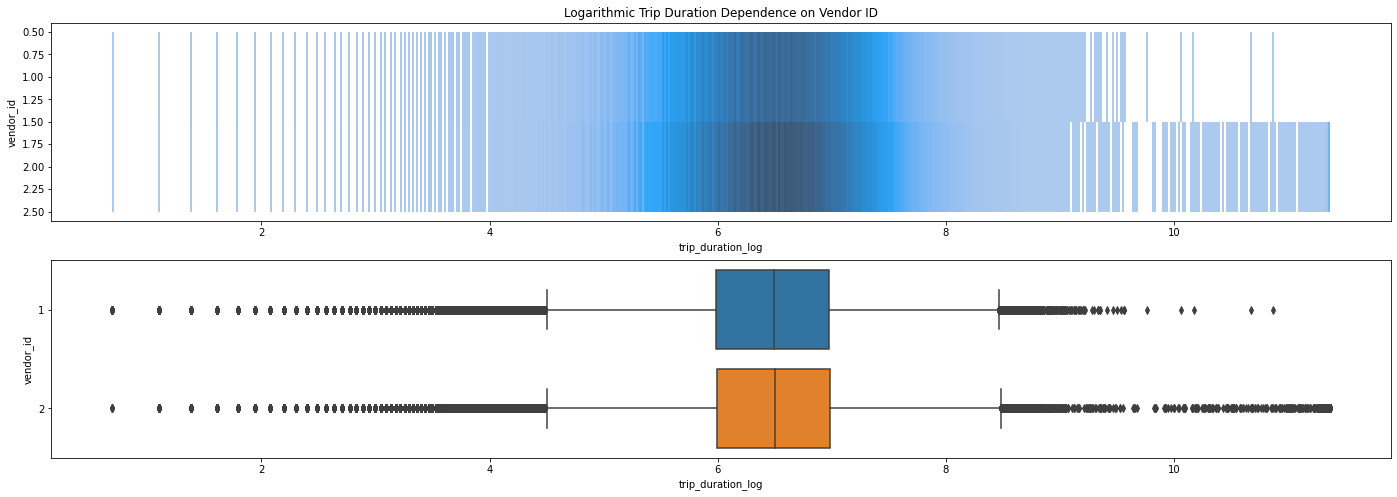

In [33]:
# Converting the vendor_id attribute to a categorical data type
taxi_df['vendor_id'] = taxi_df['vendor_id'].astype('category')


# Set chart parameters
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (24, 8))


# Building a histogram
histplot = sns.histplot(
    data = taxi_df,
    x = 'trip_duration_log',
    y = 'vendor_id',
    ax = axes[0]
);

# Histogram name
histplot.set_title('Logarithmic Trip Duration Dependence on Vendor ID')


# Building a box plot
boxplot = sns.boxplot(
    data = taxi_df,
    x = 'trip_duration_log',
    y = 'vendor_id',
    ax = axes[1]
);

**Conclusion:** 

The distributions in the groups practically do not differ, the `vendor_id` feature does not matter when determining the duration of the trip.

#### $3.3$ 

Let's build a visualization that will allow us to compare the distribution of trip duration on a logarithmic scale ($trip\_duration\_log$), depending on the sign of sending a message to the taxi fleet (`store_and_fwd_flag`).

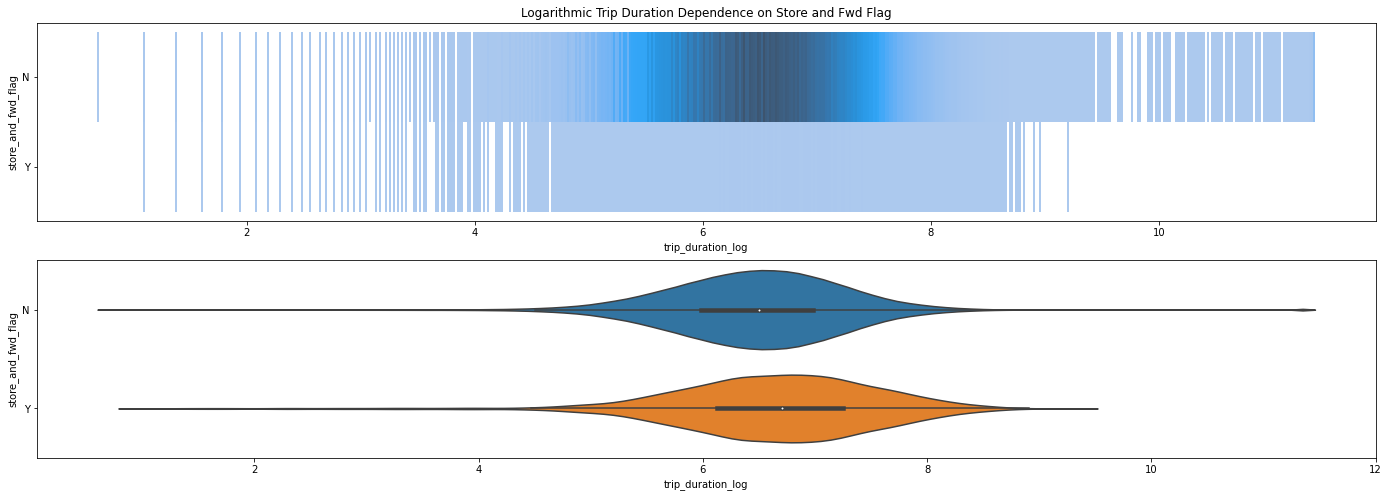

In [34]:
# Converting the 'store_and_fwd_flag' feature to a categorial data type
taxi_df.store_and_fwd_flag = taxi_df.store_and_fwd_flag.astype('category')


# Set chart parameters
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (24, 8))



# Building a histogram
histplot = sns.histplot(
    data = taxi_df,
    x = 'trip_duration_log',
    y = 'store_and_fwd_flag',
    ax = axes[0]
);

# Histogram name
histplot.set_title('Logarithmic Trip Duration Dependence on Store and Fwd Flag')



# Building a violinplot plot
boxplot = sns.violinplot(
    data = taxi_df,
    x = 'trip_duration_log',
    y = 'store_and_fwd_flag',
    ax = axes[1]
);

**Conclusion:** 

The distributions in the groups are significantly different, the store_and_fwd_flag feature is important in determining the duration of the trip.

#### $3.4$ 

Building two visualizations:

* distribution of the count of trips depending on the hour of the day,
* dependence of the median trip duration on the hour of the day

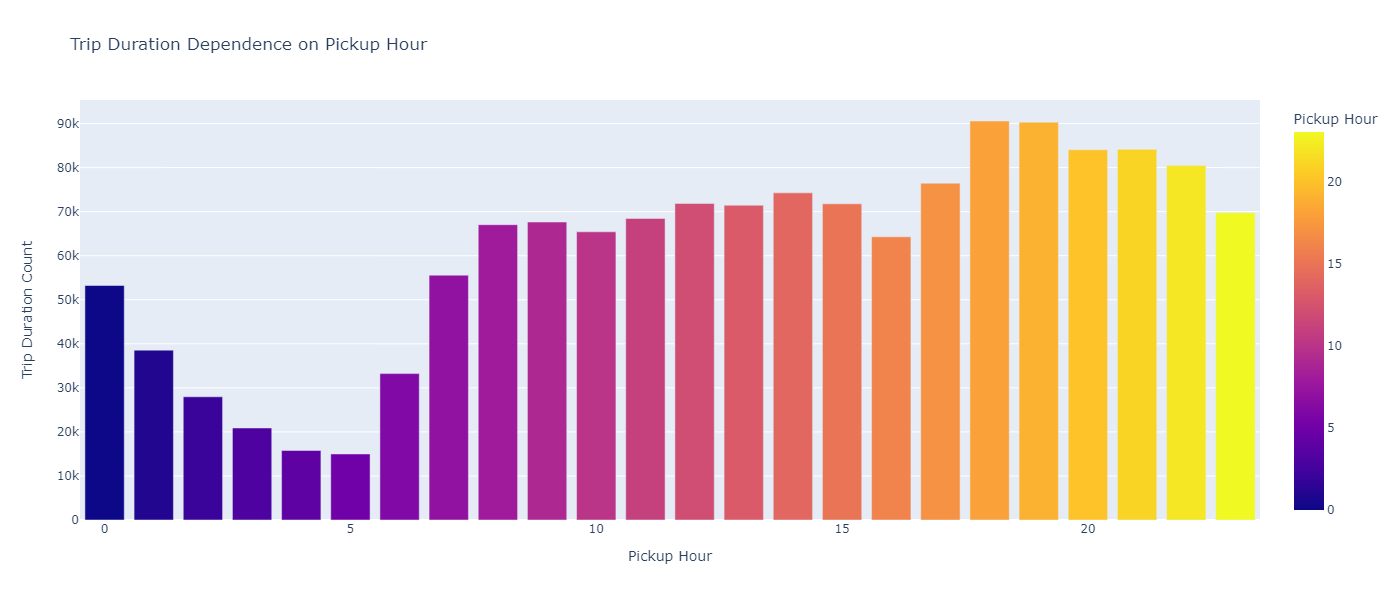

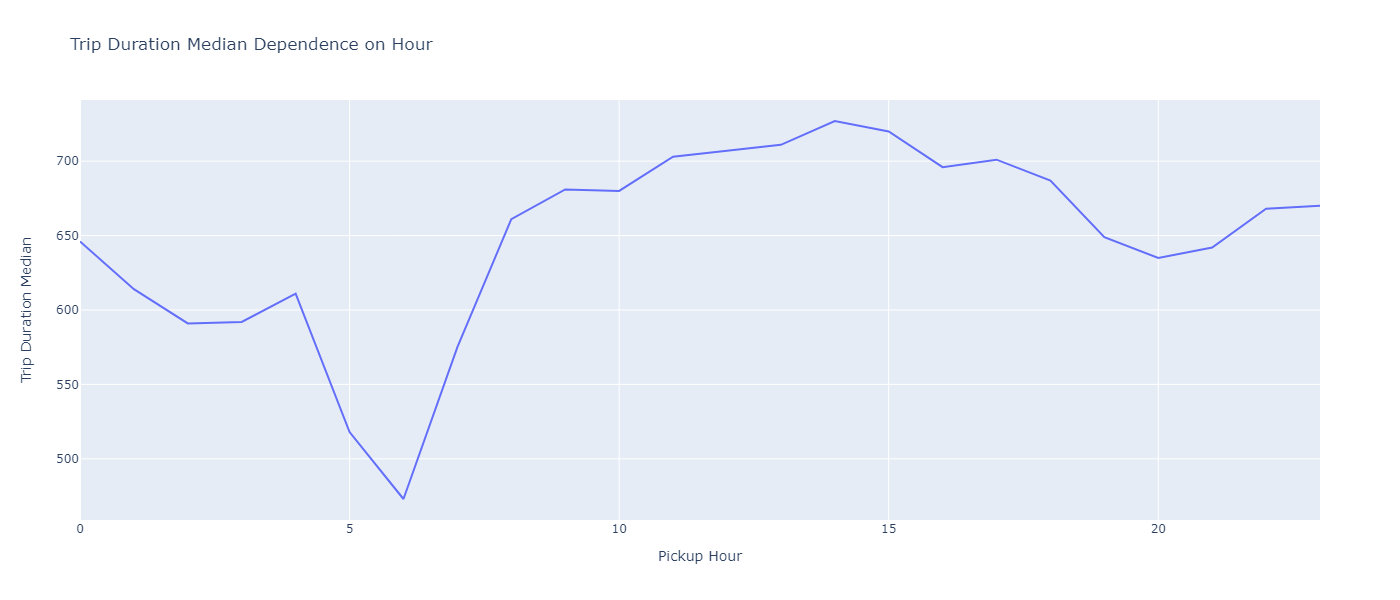

In [36]:
# Counting the number of trips
bar_data = taxi_df.groupby(
    by = 'pickup_hour',
    as_index = False
)[['trip_duration']].count()



# Building a bar chart
fig = px.bar(
    data_frame = bar_data,                             # DataFrame
    x = 'pickup_hour',                                 # x-axis
    y = 'trip_duration',                               # y-axis
    color = 'pickup_hour',                             # color depending on the pickup hour                    
    orientation = 'v',                                 # graph orientation
    height = 600,                                      # graph height 
    width = 1400,                                      # graph width
    
    labels = {
        'pickup_hour': 'Pickup Hour',                  # x-axis name
        'trip_duration': 'Trip Duration Count'         # y-axis name
    },
    
    title = 'Trip Duration Dependence on Pickup Hour'  # graph title
)

# Displaying a bar chart
fig.show('png')





# Counting the median values of trip duration
line_data = taxi_df.groupby(
    by = 'pickup_hour',
    as_index = False
)[['trip_duration']].median()



# Counting the median values of trip duration
line_data = taxi_df.groupby(
    by = 'pickup_hour',
    as_index = False
)[['trip_duration']].median()


# Building a line chart
fig = px.line(
    data_frame = line_data,                             # DataFrame
    x = 'pickup_hour',                                  # x-axis
    y = 'trip_duration',                                # y-axis
    height = 600,                                       # graph height 
    width = 1400,                                       # graph width
    
    labels = {
        'pickup_hour': 'Pickup Hour',                   # x-axis name
        'trip_duration': 'Trip Duration Median'         # y-axis name
    },
    
    title = 'Trip Duration Median Dependence on Hour'   # graph title
)

# Displaying a line chart
fig.show('png')

**Conclusions:** 

* Less often, taxis are ordered in the interval from 00:00 to 05:00 hours.
* The peak of the median duration of trips is observed in the interval from 13:00 to 18:00.

#### $3.5$ 

Building two visualization:

* distribution of the count of trips depending on the day of the week,
* dependence of the median trip duration on the day of the week

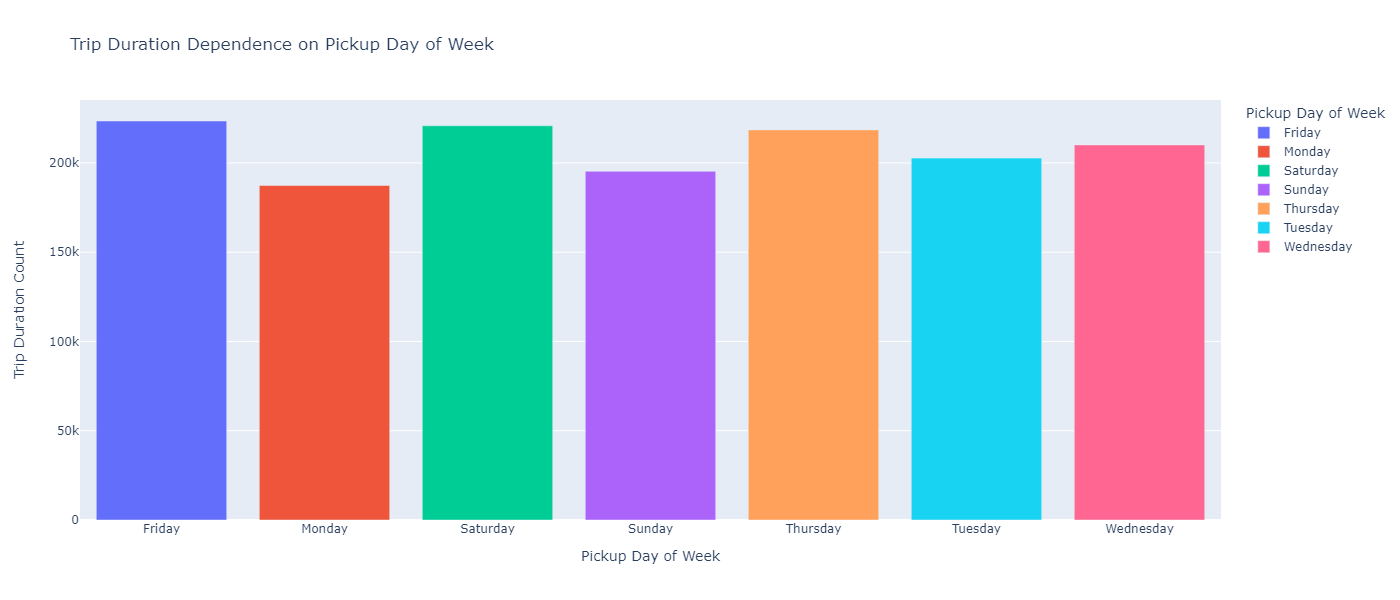

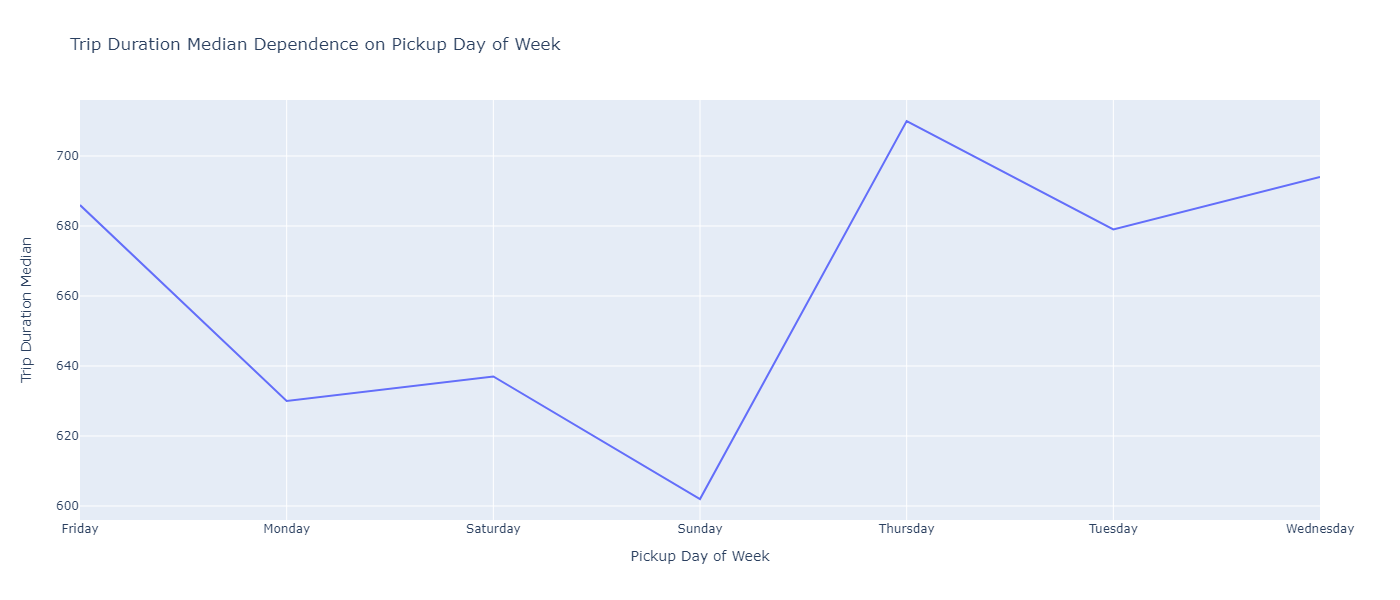

In [37]:
# Converting the 'pickup_day_of_week' feature to a categorial data type
taxi_df.pickup_day_of_week = taxi_df.pickup_day_of_week.astype('category')


# Counting the number of trips
bar_data = taxi_df.groupby(
    by = 'pickup_day_of_week',
    as_index = False
)[['trip_duration']].count()



# Building a bar chart
fig = px.bar(
    data_frame = bar_data,                                    # DataFrame
    x = 'pickup_day_of_week',                                 # x-axis
    y = 'trip_duration',                                      # y-axis
    color = 'pickup_day_of_week',                             # color depending on the pickup hour                    
    orientation = 'v',                                        # graph orientation
    height = 600,                                             # graph height 
    width = 1400,                                             # graph width
    
    labels = {
        'pickup_day_of_week': 'Pickup Day of Week',           # x-axis name
        'trip_duration': 'Trip Duration Count'                # y-axis name
    },
    
    title = 'Trip Duration Dependence on Pickup Day of Week'  # graph title
)

# Displaying a bar chart
fig.show('png')




# Counting the median values of trip duration
line_data = taxi_df.groupby(
    by = 'pickup_day_of_week',
    as_index = False
)[['trip_duration']].median()



# Counting the median values of trip duration
line_data = taxi_df.groupby(
    by = 'pickup_day_of_week',
    as_index = False
)[['trip_duration']].median()


# Building a line chart
fig = px.line(
    data_frame = line_data,                             # DataFrame
    x = 'pickup_day_of_week',                                  # x-axis
    y = 'trip_duration',                                # y-axis
    height = 600,                                       # graph height 
    width = 1400,                                       # graph width
    
    labels = {
        'pickup_day_of_week': 'Pickup Day of Week',                   # x-axis name
        'trip_duration': 'Trip Duration Median'         # y-axis name
    },
    
    title = 'Trip Duration Median Dependence on Pickup Day of Week'   # graph title
)

# Displaying a line chart
fig.show('png')

**Conclusions:**

* Most trips are made on Friday,
* The median duration of trips is the smallest on Sunday.

#### $3.6$ 

Let's build a `pivot table`, the rows of which plot hours (*pickup_hour*), the columns are the days of the week (*pickup_day_of_week*), and the cells are the median duration of the trip (*trip_duration*).

In [38]:
# Building a pivot table
taxi_pivot_table = taxi_df.pivot_table(
    values = 'trip_duration',
    index = 'pickup_hour',
    columns = 'pickup_day_of_week',
    aggfunc = 'median'
).round()

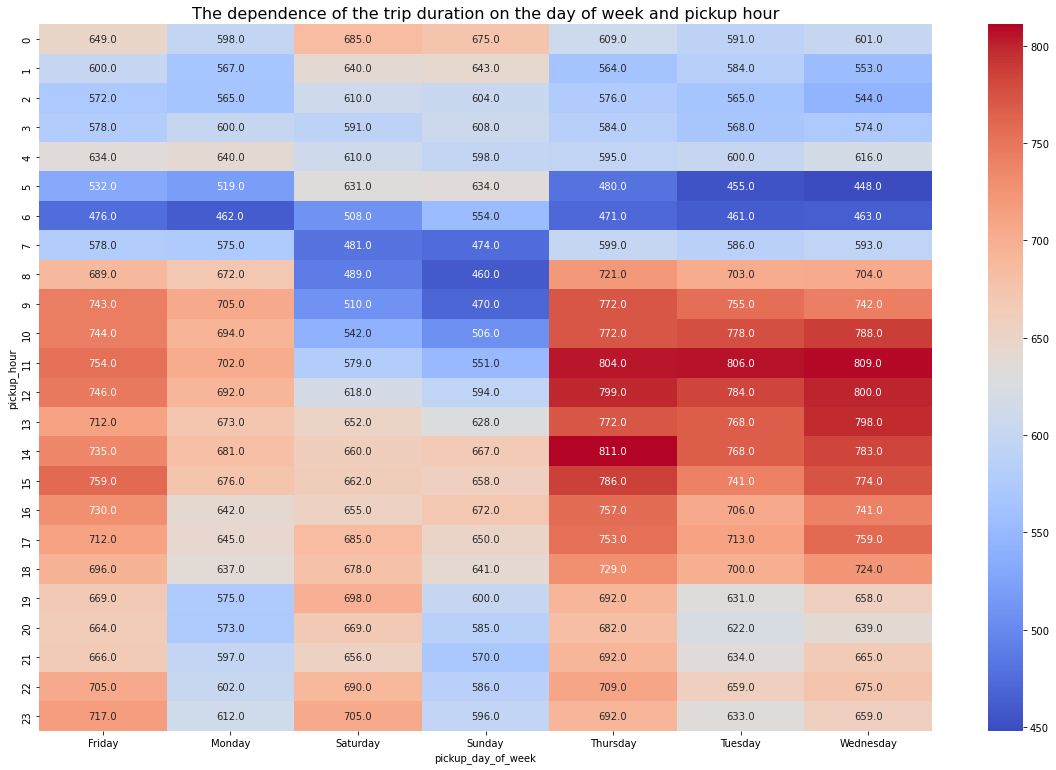

In [39]:
# Chart parameters
plt.rcParams['figure.figsize'] = (20, 13)

# Building a heatmap
heatmap = sns.heatmap(
    data = taxi_pivot_table,
    annot = True,
    cmap = 'coolwarm',
    fmt = '.1f'
)

# Heatmap name
heatmap.set_title('The dependence of the trip duration on the day of week and pickup hour', fontsize = 16);

**Conclusions:**

* The longest trips (in the median sense) are observed from Monday to Friday between 8 am and 6 pm.
* The longest median trip duration was on Thursday at 2 pm.

#### $3.7$ 

Building two scatterplots:

* geographical location of pickup points (*pickup_longitude, pickup_latitude*);
* geographical location of dropoff points (*dropoff_longitude, dropoff_latitude*).

c:\Users\ilyaz\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



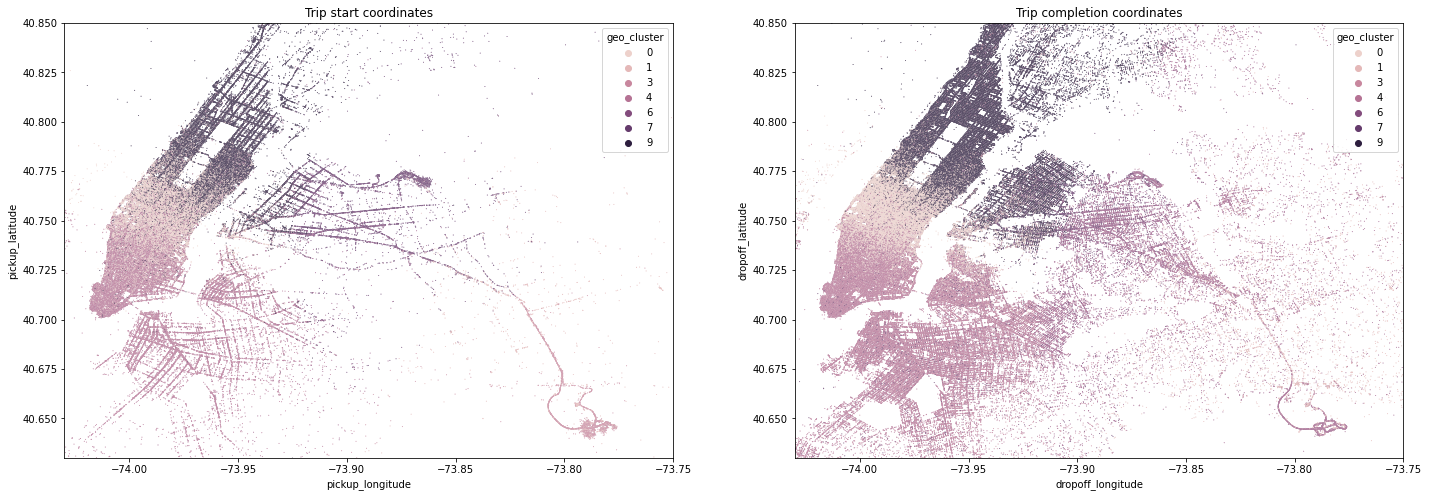

In [40]:
# Include in the visualization only those points that are within New York
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)


# Set the charts parameters
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 8))



# Building a pickup scatterplot
scatter_pickup = sns.scatterplot(
    data = taxi_df,
    x = 'pickup_longitude',
    y = 'pickup_latitude',
    hue = 'geo_cluster',
    s = 1,
    ax = axes[0]
)

# scatter pickup parameters
scatter_pickup.set_title('Trip start coordinates')
scatter_pickup.set_xlim(city_long_border)
scatter_pickup.set_ylim(city_lat_border)



# Building a dropoff scatterplot
scatter_dropoff = sns.scatterplot(
    data = taxi_df,
    x = 'dropoff_longitude',
    y = 'dropoff_latitude',
    hue = 'geo_cluster',
    s = 1,
    ax = axes[1]
)

# scatter dropoff parameters
scatter_dropoff.set_title('Trip completion coordinates')
scatter_dropoff.set_xlim(city_long_border)
scatter_dropoff.set_ylim(city_lat_border);

**Conclusion:** 

Three clusters (out of ten) did not make it to the charts (they are located outside New York).

## <center> **`4.` Selection and transformation of features**

Let's check the DataFrame data

In [41]:
print('Shape of data: {}'.format(taxi_df.shape))
print('Columns: {}'.format(taxi_df.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'holiday', 'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'direction', 'geo_cluster', 'temperature',
       'visibility', 'wind speed', 'precip', 'events', 'trip_duration_log'],
      dtype='object')


For convenience, let's make a copy of the original table with trips:

In [ ]:
# Create a copy
train_data = taxi_df.copy()

# Output the first five strings
train_data.head()

#### $4.1$ 

Of all the features that do not carry useful information in determining its duration, is `id` feature. The `dropoff_datetime` feature creates a data leak, since starting a trip, we cannot know exactly when it will end, because we are just trying to predict the end time of the trip. Let's remove the indicated features from the data set.

In [43]:
# We exclude the features 'id' and 'dropoff_time' from the source table with data
train_data = train_data.drop(['id', 'dropoff_datetime'], axis = 1)
print(f'The count of columns in the DataFrame: {train_data.shape[1]}')

The count of columns in the DataFrame: 25


Remove the `pickup_datetime` and `pickup_date` features, since we don't need them anymore:

In [44]:
# Create a drop_columns list
drop_columns = ['pickup_datetime', 'pickup_date']

# We exclude the features 'pickup_datetime' and 'pickup_date' from the source table with data
train_data = train_data.drop(drop_columns, axis = 1)

print(f'Shape of the DataFrame: {train_data.shape}')

Shape of the DataFrame: (1458233, 23)


Now let's deal with the coding of categorical features. In our data, the following features can be classified as categorical:

* `vendor_id`;
* `store_and_fwd_flag`;
* `pickup_day_of_week`;
* `geo_cluster`;
* `events`.

#### $4.2$ 

Encoding the `vendor_id` and `store_and_fwd_flag` features. 

The first two (`vendor_id` and `store_and_fwd_flag`) are binary (have two unique values). Let's encode them using a $lambda$-function.

In [45]:
# Let's encode the 'vendor_id' feature in such a way that it is equal to 0 if the taxi fleet identifier is equal to 1, and 1 otherwise
train_data.vendor_id = train_data.vendor_id.apply(lambda x: 0 if x == 1 else 1).astype(int)

# Let's encode the 'store_and_fwd_flag' feature in such a way that it is equal to 0 if the taxi fleet identifier is equal to 'N', and 1 otherwise
train_data.store_and_fwd_flag = train_data.store_and_fwd_flag.apply(lambda x: 0 if x == 'N' else 1).astype(int)

In [46]:
# Calculate the average over the encoded 'vendor_id' column. The answer will be rounded to the second decimal place after the decimal point.
print('Average over the encoded "vendor_id" column is: {}'.format(round(train_data.vendor_id.mean(), 2)))

# Calculate the average over the encoded 'store_and_fwd_flag' column. The answer will be rounded to the third decimal place after the decimal point.
print('Average over the encoded "store_and_fwd_flag" column is: {}'.format(round(train_data.store_and_fwd_flag.mean(), 3)))

Average over the encoded "vendor_id" column is: 0.53
Average over the encoded "store_and_fwd_flag" column is: 0.006


#### $4.3$ 

Encoding the `pickup_day_of_week`, `geo_cluster` and `events` features.

The next three features (`pickup_day_of_week`, `geo_cluster`, `events`) are nominal. For them, $OneHotEncoding$ is perfect.

In [47]:
# Create an instance of the class OneHotEncoder()
oh_encoder = preprocessing.OneHotEncoder(drop = 'first')

# Create a list with columns to change
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

# Encoding the data
data_onehot = oh_encoder.fit_transform(train_data[columns_to_change]).toarray() 

# Get encoded column names
column_names = oh_encoder.get_feature_names_out()

# Create a new DataFrame with encoded features
data_onehot = pd.DataFrame(data=data_onehot, columns=column_names)

# Output the count of new binary columns
print('The count of new binary columns is: {}'.format(data_onehot.shape[1]))

The count of new binary columns is: 18


Add the resulting table with encoded features:

In [48]:
# Combining both datasets
train_data = pd.concat(
    [train_data.reset_index(drop = True).drop(columns_to_change, axis=1), data_onehot],
    axis = 1
)

Now that the categorical features are preprocessed, let's form the observation matrix `X`, the vector of the target variable `y` and its logarithm `y_log`. The observation matrix will include all columns from the table with trips, except for the target feature `trip_duration` and its logarithmic version `trip_duration_log`:

In [49]:
# Compose the matrix of observations X
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis = 1)

# Compose the vector of correct answers y
y = train_data['trip_duration']

# Compose the vector of correct answers y_log
y_log = train_data['trip_duration_log']

We will train all our models on the log version of `y_log`.

Next, we need to determine the **type of validation** - the scheme by which we will evaluate the quality of the built models. Since our data set is quite large (nearly 1.5 million observations), we are free to use *hold-out* validation. Using *k-fold* validation and even more so *leave-one-out* validation with such a volume of data will be redundant and time-consuming.

Let's divide the sample into training and validation in the ratio 67/33:

In [50]:
# Spliting data with sklearn into training and valid data
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(X, y_log, test_size=0.33, random_state=42)

#### $4.4$ 

Using `SelectKBest`, we will select 25 features that are best suited for predicting the target variable on a logarithmic scale. We implement the selection based on the training sample using the `score_func = f_regression parameter`.

In [51]:
# Creating a selector KBest
selector = feature_selection.SelectKBest(
    score_func = feature_selection.f_regression,
    k = 25
)

# Apply the resulting selector to the train selections
selector.fit(X_train, y_train_log)

# Using only selected features
important_features = selector.get_feature_names_out()
X_train = X_train[important_features]
X_valid = X_valid[important_features]

# Output the selected features
print('The selected features are:\n {}'.format(important_features))

The selected features are:
 ['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_Monday'
 'pickup_day_of_week_Saturday' 'pickup_day_of_week_Sunday'
 'pickup_day_of_week_Thursday' 'pickup_day_of_week_Tuesday'
 'pickup_day_of_week_Wednesday' 'geo_cluster_1' 'geo_cluster_3'
 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_9']


#### $4.5$ 

We normalize the predictors in the training and validation sets using `MinMaxScaler` from the *sklearn* library.

Let's look at the distribution of features. Let's build a graph of the distribution of features.

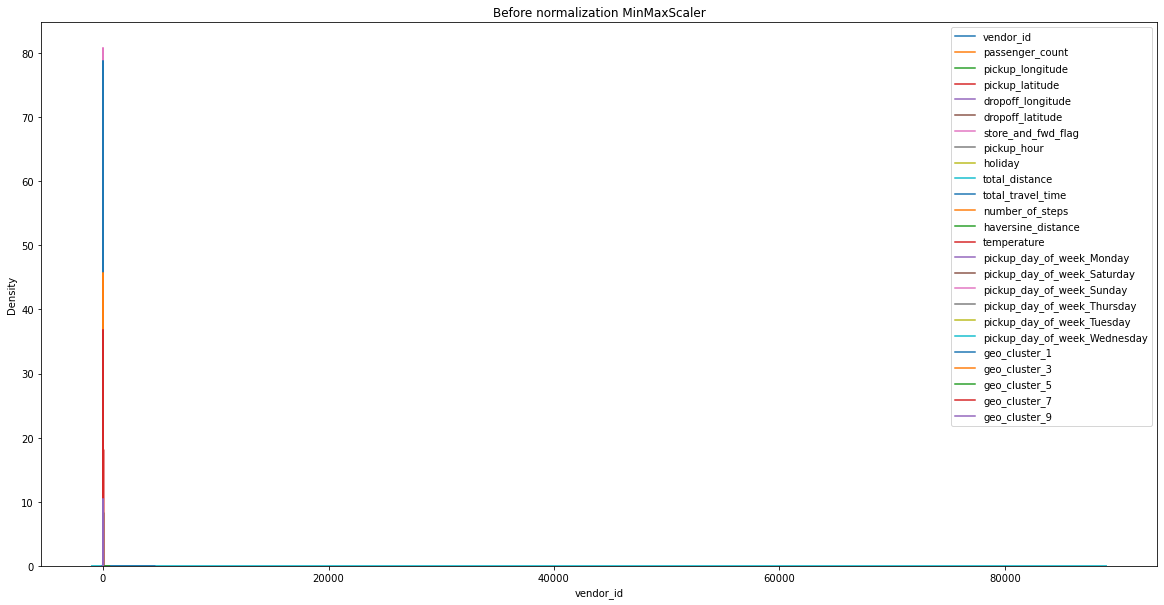

In [37]:
# Set the chart parameters
fig, (ax) = plt.subplots(ncols=1, figsize=(20, 10))
ax.set_title('Before normalization MinMaxScaler')

# Building a graph
for column in X_train.columns:
    sns.kdeplot(X_train[column], ax=ax, label=column)
    
plt.legend()

We will be using a *min-max*-normalization.

In [52]:
# Initialize the MinMaxScaler normalizer
mm_scaler = preprocessing.MinMaxScaler()

# Encoding the data
X_train = mm_scaler.fit_transform(X_train)
X_valid = mm_scaler.transform(X_valid)

# Calculating the arithmetic mean for the first predictor from the validation set. 
# The answer will be rounded to the second decimal place after the decimal point.
print('Arithmetic mean for the first predictor from the validation set is: {}'.format(np.round(np.mean(X_valid[:, 0]), 2)))

# Compose a DataFrame from arrays
X_train = pd.DataFrame(X_train, columns = important_features)
X_valid = pd.DataFrame(X_valid, columns = important_features)

Arithmetic mean for the first predictor from the validation set is: 0.54


## <center> **`5.` Solving a Regression Task: Linear Regression and Decision Trees**

Let's define a metric by which we will measure the quality of our models. As a metric, let's take **RMSLE (Root Mean Squared Log Error)**, which is calculated as:

$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$

where:

* $y_i$ - true duration of the $i$-th taxi ride (`trip_duration`)
* $\hat{y_i}$ - model-predicted duration of the $i$-th taxi ride

Note that we have already taken the logarithm of the target feature, so it will be enough for us to calculate the *RMSLE* metric for a model trained to predict the duration of a taxi trip on a logarithmic scale:

$$z_i=log(y_i+1),$$

$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$

To begin with, we will use the simplest regression model that we know of - the classic linear regression using the *OLS* method.

#### $5.1$ 
Let's build a linear regression model on the training sample (we use the target variable on a logarithmic scale). We will leave all parameters by default. 

For the resulting model, we calculate the *RMSLE* metric on the training and validation sets. The answer **will be rounded to the second decimal place after the decimal point**.

In [76]:
# Creating a object of linear regression class
lr_reg = linear_model.LinearRegression()

# Training the model
lr_reg.fit(X_train, y_train_log)

# Making a prediction for train set
y_train_predict = lr_reg.predict(X_train)

# Making a prediction for validation set
y_valid_predict = lr_reg.predict(X_valid)

# Calculating RMSLE
print('RMSLE on the training set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)), 2)))
print('RMSLE on the validation set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)), 2)))

RMSLE on the training set: 0.54
RMSLE on the validation set: 0.54


#### $5.2$

Let's generate polynomial features of the second degree using `PolynomialFeatures` from the *sklearn* library. Let's take `False` as the value of the `include_bias` parameter.

Then we will build a second-degree polynomial regression model on the training set. We will leave all parameters by default.

For the resulting model, we calculate the *RMSLE* metric on the training and validation sets. The answer **will be rounded to the second decimal place after the decimal point**.

In [40]:
# Creating a polynomial feature generator
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

# Training the polynomial feature generator
poly.fit(X_train)

# Generating the polynomial features for the trainig set
X_train_poly = poly.transform(X_train)

# Generating the polynomial features for the validation set
X_valid_poly = poly.transform(X_valid)

# Creating the object of Linear regression class
lr_model_poly = linear_model.LinearRegression()

# Training the model
lr_model_poly.fit(X_train_poly, y_train_log)

# Making a prediction for train set
y_train_predict = lr_model_poly.predict(X_train_poly)

# Making a prediction for validation set
y_valid_predict = lr_model_poly.predict(X_valid_poly)

# Calculating RMSLE
print('RMSLE on the training set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)), 2)))
print('RMSLE on the validation set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)), 2)))

RMSLE on the training set: 0.47
RMSLE on the validation set: 0.7


#### $5.3$

Let us build a second-degree polynomial regression model with $L_2$-regularization (Tikhonov regularization) on the training set. Set the regularization coefficient to 1, leave the rest of the parameters as default.

For the resulting model, we calculate the *RMSLE* metric on the training and validation sets. The answer **will be rounded to the second decimal place after the decimal point**.

In [41]:
# Creating a linear regression class object with L2-regularization
lr_model_ridge = linear_model.Ridge(alpha = 1)

# Training the model
lr_model_ridge.fit(X_train_poly, y_train_log)

# Making a prediction for train set
y_train_predict = lr_model_ridge.predict(X_train_poly)

# Making a prediction for validation set
y_valid_predict = lr_model_ridge.predict(X_valid_poly)

# Calculating RMSLE
print('RMSLE on the training set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)), 2)))
print('RMSLE on the validation set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)), 2)))

RMSLE on the training set: 0.48
RMSLE on the validation set: 0.48


#### $5.4$

Now let's try to build a decision tree model (`DecisionTreeRegressor`) on the training set. We will leave all parameters by default, but set the value of the parameter `random_state = 42`.

For the resulting model, we calculate the *RMSLE* metric on the training and validation sets. The answer **will be rounded to the second decimal place after the decimal point**.

In [42]:
# Creating a DecisionTreeRegressor object
dt_reg = tree.DecisionTreeRegressor(random_state = 42)

# Training the model
dt_reg.fit(X_train, y_train_log)

# Making a prediction for train set
y_train_predict = dt_reg.predict(X_train)

# Making a prediction for validation set
y_valid_predict = dt_reg.predict(X_valid)

# Calculating RMSLE
print('RMSLE on the training set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)), 2)))
print('RMSLE on the validation set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)), 2)))

RMSLE on the training set: 0.0
RMSLE on the validation set: 0.57


#### $5.5$

Going through all the possible options for the depth of the decision tree. Let us build linear graphs of *RMSLE* metric change on the training and validation samples depending on the value of the decision tree depth parameter.

For the resulting model, we calculate the *RMSLE* metric on the training and validation sets. The answer **will be rounded to the second decimal place after the decimal point**.

Optimal Decision Tree Depth: 12
RMSLE on training set: 0.41
RMSLE on validation set: 0.43


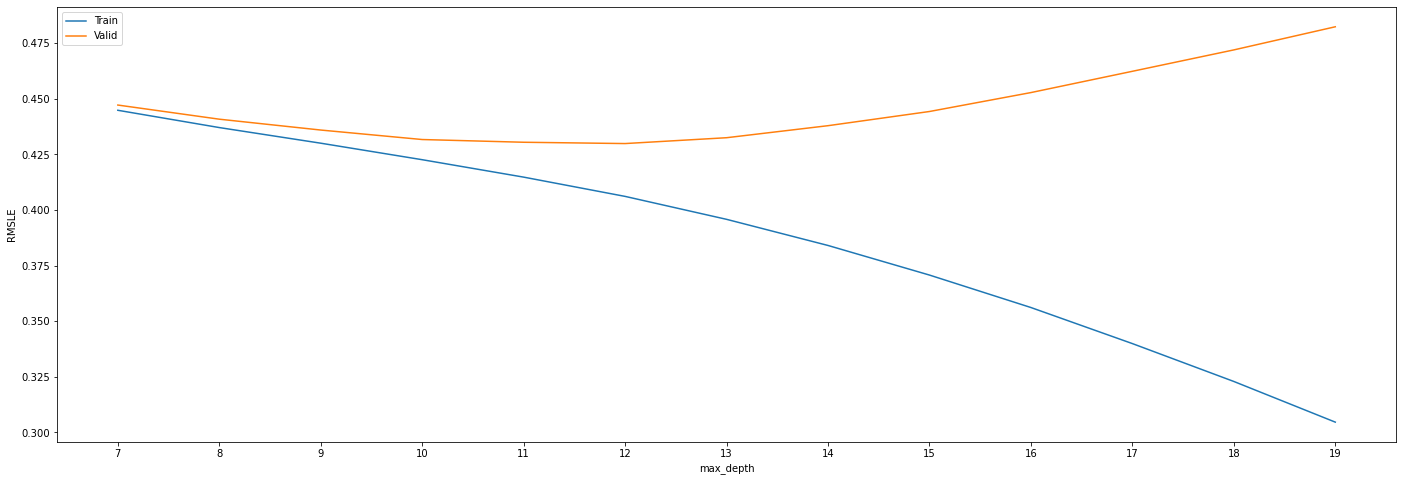

In [43]:
# Creating a range of numbers from 7 to 20
max_depth_list = range(7, 20)



# Creating a blank lists for depth values
train_depth_values = []
valid_depth_values = []



for value in max_depth_list:
    
    # Creating a DecisionTreeRegressor object of class
    dt_reg = tree.DecisionTreeRegressor(max_depth = value, random_state = 42)
    
    # Training the model
    dt_reg.fit(X_train, y_train_log)
    
    # Making a prediction for train set
    y_train_predict = dt_reg.predict(X_train)
    
    # Making a prediction for validation set
    y_valid_predict = dt_reg.predict(X_valid)
    
    # Calculating RMSLE values and add it to lists
    train_depth_values.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)))
    valid_depth_values.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)))
    
    
    
# Building a linear graphs of RMSLE metrics
fig, ax = plt.subplots(figsize = (24, 8))                     # figure + coordinate plane
ax.plot(max_depth_list, train_depth_values, label = 'Train')  # line plot for the training set
ax.plot(max_depth_list, valid_depth_values, label = 'Valid')  # line plot for the validation set
ax.set_xlabel('max_depth')                                    # x-axis name
ax.set_ylabel('RMSLE')                                        # y-axis name
ax.set_xticks(max_depth_list)                                 # x-axis labels
ax.legend();                                                  # legend display

# Extract the index of the best RMSLE on the validation set
best_index = valid_depth_values.index(min(valid_depth_values))
print('Optimal Decision Tree Depth: {}'.format(max_depth_list[best_index], 2))
print('RMSLE on training set: {}'.format(round(train_depth_values[best_index], 2)))
print('RMSLE on validation set: {}'.format(round(valid_depth_values[best_index], 2)))

## <center> **`6.` Solving the Regression Task: Ensemble Methods and Building a Forecast**

#### $6.1$

Now let's build a random forest model on the training set. We specify the following as hyperparameters:

* `n_estimators = 200`;
* `max_depth = 12`;
* `criterion = 'squared_error'`;
* `min_samples_split = 20`;
* `random_state = 42`.

For the resulting model, we calculate the *RMSLE* metric on the training and validation sets. The answer **will be rounded to the second decimal place after the decimal point**.

In [53]:
# Creating the RandomForestRegressor object
rf_regr = ensemble.RandomForestRegressor(
    
    n_estimators = 200,            # count of trees in the ensemble
    max_depth = 12,                # maximum tree depth
    criterion = 'squared_error',   # informative criterion
    min_samples_split = 20,        # minimum count of split
    random_state = 42              # random number generator
    
)


# Training the model on train set
rf_regr.fit(X_train, y_train_log)

# Making a prediction for train set
y_train_predict = rf_regr.predict(X_train)

# Making a prediction for validation set
y_valid_predict = rf_regr.predict(X_valid)

# Calculating RMSLE
print('RMSLE on the training set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)), 2)))
print('RMSLE on the validation set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)), 2)))

RMSLE on the training set: 0.4
RMSLE on the validation set: 0.41


By training several trees in parallel, the random forest model gave us a small quality gain compared to a conventional decision tree.

Let's see what happens with **sequential ensemble ↓**

#### $6.2$

Let's build a model of gradient boosting over decision trees (`GradientBoostingRegressor`) on the training sample. We specify the following as hyperparameters:

* l`earning_rate` = 0.5;
* `n_estimators` = 100;
* `max_depth` = 6;
* `min_samples_split` = 30;
* `random_state` = 42.

For the resulting model, we calculate the *RMSLE* metric on the training and validation sets. The answer **will be rounded to the second decimal place after the decimal point**.

In [36]:
# Creating the GradientBoostingRegressor object
gb_regr = ensemble.GradientBoostingRegressor(
    
    learning_rate = 0.5,      # pace of learning
    n_estimators = 100,       # count of trees in the ensemble
    max_depth = 6,            # maximum tree depth
    min_samples_split = 30,   # minimum count of split
    random_state = 42         # random number generator
    
)


# Training the model on train set
gb_regr.fit(X_train, y_train_log)

# Making a prediction for train set
y_train_predict = gb_regr.predict(X_train)

# Making a prediction for validation set
y_valid_predict = gb_regr.predict(X_valid)

# Calculating RMSLE
print('RMSLE on the training set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)), 2)))
print('RMSLE on the validation set: {}'.format(round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)), 2)))

RMSLE on the training set: 0.37
RMSLE on the validation set: 0.39


**Conclusion:** 

Of all the constructed models, the `Gradient boosting model over decision trees` showed the best result.

#### $6.3$

Let's build a bar graph of the coefficients of significance of each of the factors.

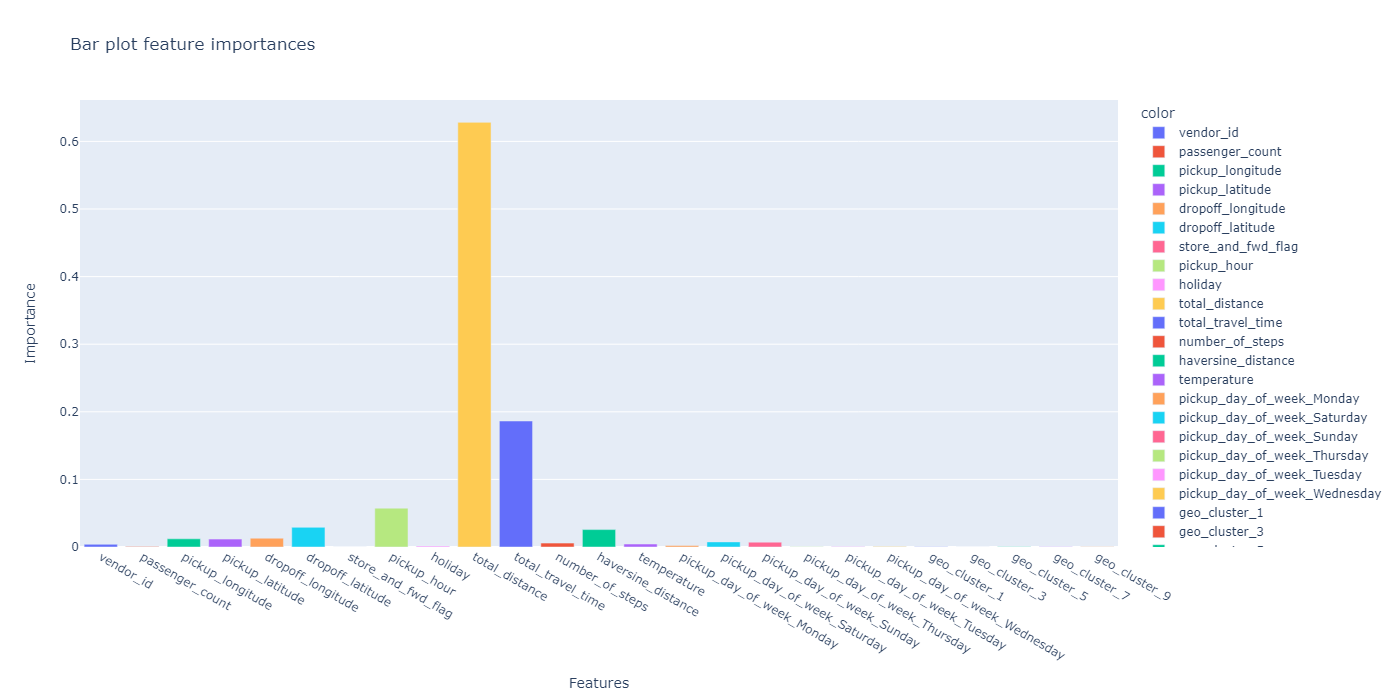

In [37]:
# Setting the bar graph parameters             
features = X_train.columns                           # features
importances_features = gb_regr.feature_importances_  # importance of features


# Building a bar graph
fig = px.bar(
    x = features,
    y = importances_features,
    color = features,
    orientation = 'v',
    height = 700,
    width = 1400,
    
    labels = {
        'x': 'Features',
        'y': 'Importance'
    },
    
    title = 'Bar plot feature importances'
)

fig.show('png')

Despite all the advantages, the RMSLE metric has one drawback - it is not interpretable. We would like to understand how well our final model predicts the target feature from a business process point of view.

#### $6.5$

For the best of the built models, calculate the median absolute error (*MeAE*, in *sklearn* - the `median_absolute_error` function) of predicting the duration of a taxi trip on the validation set:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

The *MeAE* metric value **will be converted to minutes and rounded up to tenths**.

In [79]:
# Convert from logarithmic scale to original
y_valid = np.exp(y_valid_log) - 1
y_valid_predict_exp = np.exp(y_valid_predict) - 1

# Calculate the median absolute error
mae_valid = metrics.median_absolute_error(y_valid, y_valid_predict_exp)

# Convert the metric value to minutes and round
print('MeAE on validation set: {} minutes.'.format(round(mae_valid / 60, 1)))

MeAE on validation set: 1.8 minutes.


**The final step** is to *submit* (a prediction for the pending test dataset).

Let's read the test data and preselect the column with trip IDs from the test dataset.

In [80]:
# Loading a test DataFrame
test_data = pd.read_csv('Прочие файлы/Project5_test_data.csv')

# Loading a OSRM test DataFrame
osrm_data_test = pd.read_csv('Прочие файлы/Project5_osrm_data_test.csv')

# Preselecting the column with trip IDs
test_id = test_data['id']

Before creating a forecast for the test sample, it is necessary to perform all the data manipulations that we performed with the training sample, namely:

* Convert `pickup_datetime` feature to *datetime* format.

* Add new features (temporal, geographic, weather and other factors).

* Cleanup data from gaps.

* Encode categorical features:
  * encode binary features;
  * encode nominal features using `OneHotEncoder` trained on the training set;


* Form a matrix of observations, leaving in the table only those features that were selected using `SelectKBest`.

* Normalize the data using the `MinMaxScaler` trained on the training set.

In [81]:
# Converting 'pickup_datetime' feature to datetime format
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')

# Adding new features (temporal, geographic, weather and other factors)
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(df1=test_data, df2=holiday_df)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(df=test_data, cluster_model=kmeans)
test_data = add_weather_features(test_data, weather_df)

# Filling the gaps
test_data = fill_null_weather_data(test_data)

# Encoding the binary features
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

# Encoding the categorial features
test_data_onehot = oh_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = oh_encoder.get_feature_names_out(columns_to_change)

# Converting test_data_onehot to DataFrame
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

# Combining test_data and test_data_onehot
test_data = pd.concat(
    [test_data.reset_index(drop = True).drop(columns_to_change, axis=1), test_data_onehot],
    axis = 1
)

# Highlighting the best features
best_features = selector.get_feature_names_out()

# Using only the best features
X_test = test_data[best_features]

# Normalizing the data using the MinMaxScaler
X_test_scaled = mm_scaler.transform(X_test)

print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Now we will make a prediction of the duration of the trip for the test sample. We will also convert the predictions from the logarithmic scale to the true one using the formula:
$$y_i=exp(z_i)-1$$

After we generate a prediction of the duration of trips on the test sample, we will create a *submission* file in `CSV` format.

In [ ]:
# Making a prediction for the test sample
y_test_predict_log = gb_regr.predict(X_test_scaled)

# Convert predictions from logarithmic scale to true
y_test_predict = np.exp(y_test_predict_log) - 1


# Creating a DataFrame
submission = pd.DataFrame(
    {
        'id': test_id,
        'trip_duration': y_test_predict
    }
)

# Creating a submission file
submission.to_csv('submission_gb.csv', index=False)

## <center> **`7.` Improving prediction with the XGBoost model**

Before training the model, let's convert the datasets to the `xgb.DMatrix` data type:

In [82]:
# Creating observation matrices in DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=important_features)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=important_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=important_features)

Training the *XGBoost* model with `train()` method

In [83]:
# Model hyperparameters
xgb_params = {
    'min_child_weight': 20,
    'eta': 0.1,
    'colsample_bytree': 0.9,
    'max_depth': 6,
    'subsample': 0.9,
    'lambda': 1,
    'nthread': -1,
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror'
}

# Training and validation sets
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Train the XGBoost model
model = xgb.train(
    params = xgb_params,         # model hyperparameters
    dtrain = dtrain,             # training set
    num_boost_round = 300,       # number of models in the ensemble
    evals = watchlist,           # samples on which the matrix is ​​calculated
    early_stopping_rounds = 20,  # early stop
    maximize = False,            # change search for maximum to minimum
    verbose_eval = 10            # step through which metrics are displayed
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93575	valid-rmse:1.93569
[20]	train-rmse:0.78507	valid-rmse:0.78592
[30]	train-rmse:0.47892	valid-rmse:0.48093
[40]	train-rmse:0.42050	valid-rmse:0.42312
[50]	train-rmse:0.40890	valid-rmse:0.41187
[60]	train-rmse:0.40421	valid-rmse:0.40761
[70]	train-rmse:0.40130	valid-rmse:0.40512
[80]	train-rmse:0.39910	valid-rmse:0.40326
[90]	train-rmse:0.39715	valid-rmse:0.40159
[100]	train-rmse:0.39544	valid-rmse:0.40017
[110]	train-rmse:0.39415	valid-rmse:0.39928
[120]	train-rmse:0.39297	valid-rmse:0.39832
[130]	train-rmse:0.39152	valid-rmse:0.39718
[140]	train-rmse:0.39054	valid-rmse:0.39654
[150]	train-rmse:0.38924	valid-rmse:0.39552
[160]	train-rmse:0.38870	valid-rmse:0.39516
[170]	train-rmse:0.38805	valid-rmse:0.39483
[180]	train-rmse:0.38737	valid-rmse:0.39443
[190]	train-rmse:0.38648	valid-rmse:0.39376
[200]	train-rmse:0.38582	valid-rmse:0.39334
[210]	train-rmse:0.38518	valid-rmse:0.39316
[220]	train-rmse:0.38468	valid-rmse:0.39291

Let's predict the target feature using the `predict()` method:

In [84]:
# Making a prediction on a test dataset
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39078


Let's determine the factor importance coefficients using the `plot_importance()` function:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

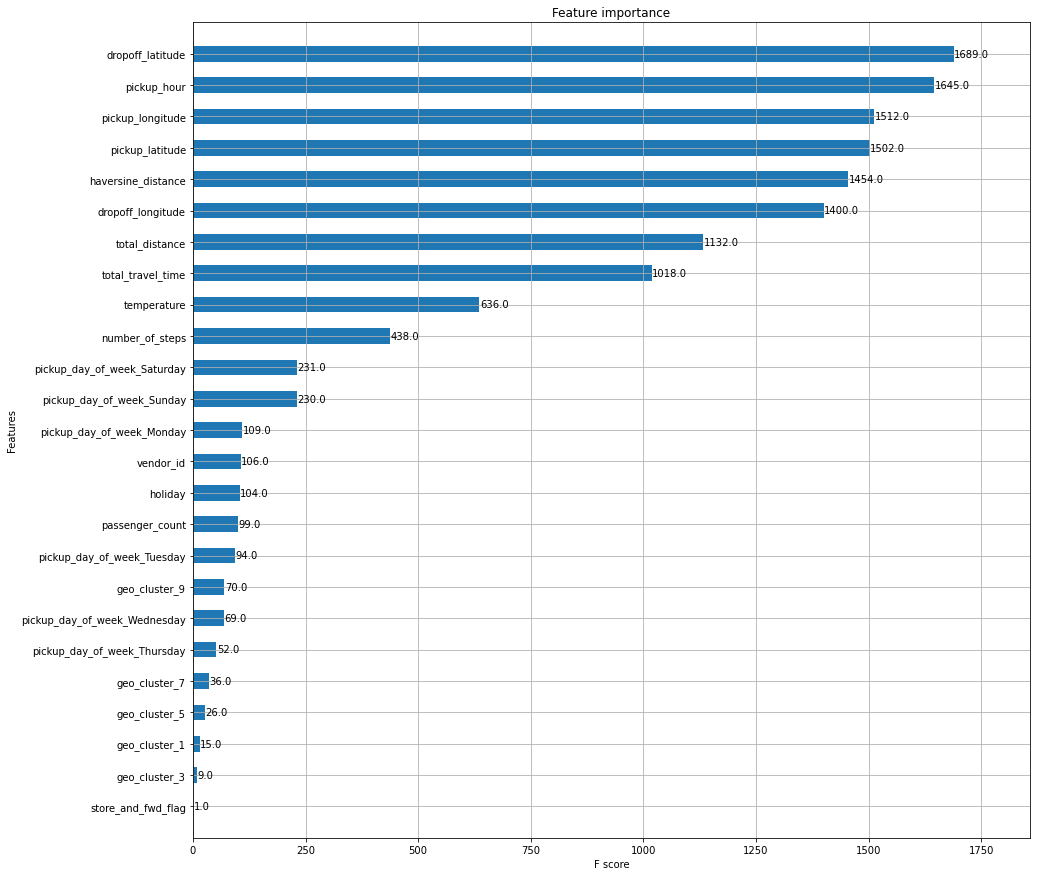

In [85]:
# Setting the graph parameters
fig, ax = plt.subplots(figsize = (15, 15))

# Building a graph
xgb.plot_importance(
    model,
    ax = ax,
    height = 0.5
)